In [1]:
import numpy as np 
import pandas as pd 
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,f1_score,average_precision_score, accuracy_score,roc_auc_score
from sklearn.model_selection import StratifiedKFold

from collections import OrderedDict

from xgboost import XGBClassifier, plot_importance
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

import warnings
warnings.filterwarnings("ignore")

Yes, applying SMOTE and SMOTE+ENN techniques on the dataset did drastically increase the performance of the CART decision tree. SMOTE+ENN technique performed the best, yielding a F1-score of 0.8564 as compared to the original F1-score of 0.131. SMOTE returned a F1-score of 0.778. However, over-weighting rows did worse than the original. It returned a F1-score of 0.096. 

Q4

In [2]:
X = pd.read_csv("train.csv")
X_test = pd.read_csv("test.csv")
y = pd.read_csv("train_labels.csv")
y_test = pd.read_csv("test_labels.csv")

Finding the best hyperparameters for XGBoost using BayesSearchCV. <br>
Note: I added the outputs as comments as the code takes quite awhile to run and differes slightly every iteration.

In [4]:
bayes_cv_tuner = BayesSearchCV(
    estimator = XGBClassifier(
        objective = 'binary:logistic',
        eval_metric = 'aucpr',
        verbosity = 1,
        tree_method='gpu_hist',
        use_label_encoder =False,
    ),
    search_spaces = {
        'learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'min_child_weight': Integer(0, 30),
        'max_depth': Integer(5, 30),
        'subsample': Real(0.01, 1.0, 'uniform'),
        'colsample_bytree': Real(0.01, 1.0, 'uniform'),
        'colsample_bylevel': Real(0.01, 1.0, 'uniform'),
        'reg_lambda': Real(1e-3, 1.0, 'log-uniform'),
        'reg_alpha': Real(1e-3, 1.0, 'log-uniform'),
        'gamma': Real(1e-3, 1.0, 'log-uniform'),
        'n_estimators': Integer(50, 200)
    },       
    scoring = 'roc_auc', #no pr_auc metric available
    cv = StratifiedKFold(
        n_splits=5,
        shuffle=True,
    ),
    n_jobs = -1,
    n_iter = 500,   
    verbose = 0,
    refit = True,
    fit_params = {
    'early_stopping_rounds':20,
    'eval_metric':'aucpr',
    'eval_set':(X, y),
}
)
results = bayes_cv_tuner.fit(X, y)

In [52]:
bayes_cv_tuner.best_params_
# OrderedDict([('colsample_bylevel', 0.4921369178306644), # These are the best parameters for XGBoost
#              ('colsample_bytree', 0.5606333654744303),
#              ('gamma', 0.001787376050236578),
#              ('learning_rate', 0.01),
#              ('max_depth', 30),
#              ('min_child_weight', 0),
#              ('n_estimators', 200),
#              ('reg_alpha', 1.0),
#              ('reg_lambda', 1.0),
#              ('subsample', 0.8577304956697562)])

OrderedDict([('colsample_bylevel', 0.4921369178306644),
             ('colsample_bytree', 0.5606333654744303),
             ('gamma', 0.001787376050236578),
             ('learning_rate', 0.01),
             ('max_depth', 30),
             ('min_child_weight', 0),
             ('n_estimators', 200),
             ('reg_alpha', 1.0),
             ('reg_lambda', 1.0),
             ('subsample', 0.8577304956697562)])

In [53]:
bayes_cv_tuner.best_score_
# 0.7629522752497225

0.7629522752497225

In [3]:
xgbc = XGBClassifier(
        objective = 'binary:logistic',
        eval_metric = 'auc',
        verbosity = 0,
        tree_method='gpu_hist', #Note: The model is ran using GPU
        use_label_encoder =False,
        colsample_bylevel= 1,
        colsample_bytree = 0.7313746962198359,
        gamma = 0.001,
        learning_rate = 0.01,
        min_child_weight = 0,
        reg_alpha =  1,
        reg_lambda = 1,
        subsample =  0.530755738635484,
        max_depth = 8,
        n_estimator = 200,
        random_state = 0
    )
xgbc.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.7313746962198359, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.001, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=8, max_leaves=0,
              min_child_weight=0, missing=nan, monotone_constraints='()',
              n_estimator=200, n_estimators=100, n_jobs=0, num_parallel_tree=1,
              predictor='auto', ...)

In [4]:
#Metrics on Train Set
predictions = xgbc.predict(X)
print("Accuracy of Model::",accuracy_score(y,predictions))
print(roc_auc_score(y,predictions))
print(f1_score(y,predictions))

Accuracy of Model:: 0.9144316730523627
0.8726827094474153
0.9399103139013453


In [5]:
#Metrics on Test Set
predictions = xgbc.predict(X_test)
print("Accuracy of Model::",accuracy_score(y_test,predictions))
print(roc_auc_score(y_test,predictions))
print(f1_score(y_test,predictions))

Accuracy of Model:: 0.7602040816326531
0.6851325757575757
0.8350877192982455


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

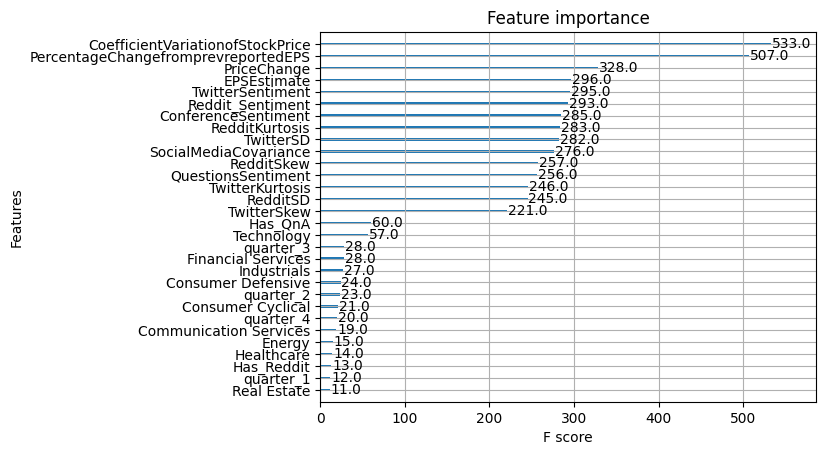

In [6]:
#plot feature importance graph
plot_importance(xgbc)